***

# G2M Insight for Cab Investment Firm

***

#### The Client

X is a private firm in US. Due to remarkable growth in the Cab Industry in last few years and multiple key players in the market, it is planning for an investment in Cab industry and as per their Go-to-Market(G2M) strategy they want to understand the market before taking final decision.

#### Approach

1. **Basic Analysis** of each dataset involving searching for null & duplicate values.
2. **Data Transformation** to create a main dataset, this can be performed using the
transaction IDs and customer IDs as well as the City location. Date of travel converted
into more usable datetime.
3. **Feature Extraction** from the dataset, providing more valuable insights – profit, cost per
km, price per km.
4. **Exploratory Analysis** to further understand the distribution functions and the
correlations which exist in the dataset. Breaking down the topic into 3 distinct main
categories – location, time, and customer.
5. **Comparative Analysis** comparing yellow and pink taxi companies to gauge their
individual performance and scale. Includes time series analysis with monthly resampling.
6. **Hypothesis Testing** on several key and interesting questions to prove their statistical
significance.

***

In [38]:
# Loading in relevant dependencies
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import display
import xlrd
import datetime as dt 
import seaborn as sns 
import statsmodels.api as sm
import scipy.stats
from statsmodels.tsa.stattools import adfuller

sns.set(rc={'figure.figsize':(20,10)})

## Loading In and Inspecting Data

In [3]:
def explore_data(data):
    """
    Offers some initial data insights prior to working with data
    Null/duplicate counts and data shape
    """
    null = data.isnull().sum().sum()
    shape = data.shape
    duplicates = data[data.duplicated()].count().sum()
    
    sample = data.sample(3)
    
    return display(sample), print(f"\n- ADDITIONAL INFO -\nShape: {shape}\nNull Value Count: {null}\nDuplicates: {duplicates}")

In [4]:
cab_df = pd.read_csv("https://raw.githubusercontent.com/DataGlacier/DataSets/main/Cab_Data.csv")
explore_data(cab_df)

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
72322,10089877,42658,Yellow Cab,NEW YORK NY,39.20,763.13,555.072
204894,10251206,43041,Yellow Cab,NEW YORK NY,11.90,327.02,157.080
141083,10173840,42870,Yellow Cab,WASHINGTON DC,27.56,625.72,330.720



- ADDITIONAL INFO -
Shape: (359392, 7)
Null Value Count: 0
Duplicates: 0


(None, None)

In [5]:
city_df = pd.read_csv("https://raw.githubusercontent.com/DataGlacier/DataSets/main/City.csv")

# Converting strings to int
city_df["Users"] = city_df["Users"].replace(",", "", regex = True).astype(int)
city_df["Population"] = city_df["Population"].replace(",", "", regex = True).astype(int)

explore_data(city_df)

,City,Population,Users
8,DALLAS TX,942908,22157
11,AUSTIN TX,698371,14978
10,DENVER CO,754233,12421



- ADDITIONAL INFO -
Shape: (20, 3)
Null Value Count: 0
Duplicates: 0


(None, None)

In [6]:
customer_df = pd.read_csv("https://raw.githubusercontent.com/DataGlacier/DataSets/main/Customer_ID.csv")
explore_data(customer_df)

,Customer ID,Gender,Age,Income (USD/Month)
30830,9848,Female,42,10863
30100,27798,Male,30,10342
44041,38333,Female,29,15534



- ADDITIONAL INFO -
Shape: (49171, 4)
Null Value Count: 0
Duplicates: 0


(None, None)

In [7]:
transaction_df = pd.read_csv("https://raw.githubusercontent.com/DataGlacier/DataSets/main/Transaction_ID.csv")
explore_data(transaction_df)

,Transaction ID,Customer ID,Payment_Mode
252542,10252553,42391,Cash
197530,10197541,4309,Cash
72958,10072969,42445,Cash



- ADDITIONAL INFO -
Shape: (440098, 3)
Null Value Count: 0
Duplicates: 0


(None, None)

In [8]:
# Note how we can gather further information on our customers by using the transaction and customer ids to merge into a main/master dataframe

In [9]:
main_df = cab_df.merge(transaction_df, on = "Transaction ID").merge(customer_df, on = "Customer ID").merge(city_df, on = "City")
explore_data(main_df)

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Population,Users
179913,10080616,42635,Yellow Cab,NEW YORK NY,11.40,325.21,162.7920,2298,Card,Male,32,21346,8405837,302149
123005,10124343,42726,Pink Cab,LOS ANGELES CA,37.80,531.36,389.3400,7161,Card,Female,33,31275,1595037,144132
192859,10123067,42714,Yellow Cab,NEW YORK NY,23.52,586.47,316.1088,240,Cash,Female,30,10273,8405837,302149



- ADDITIONAL INFO -
Shape: (359392, 14)
Null Value Count: 0
Duplicates: 0


(None, None)

In [10]:
# Adding additional interesting features
# Profit feature 
main_df['Profit'] = main_df['Price Charged'] - main_df['Cost of Trip']

# Price per km for customer
main_df["Price per KM"] = main_df["Price Charged"]/main_df["KM Travelled"]

# Cost per km for taxi 
main_df["Cost per KM"] = main_df["Cost of Trip"]/main_df["KM Travelled"]

In [11]:
main_df.describe().apply(lambda s: s.apply("{0:.2f}".format)).T

,count,mean,std,min,25%,50%,75%,max
Transaction ID,359392.00,10220761.19,126805.80,10000011.00,10110809.75,10221035.50,10330937.25,10440107.00
Date of Travel,359392.00,42964.07,307.47,42371.00,42697.00,42988.00,43232.00,43465.00
KM Travelled,359392.00,22.57,12.23,1.90,12.00,22.44,32.96,48.00
Price Charged,359392.00,423.44,274.38,15.60,206.44,386.36,583.66,2048.03
Cost of Trip,359392.00,286.19,157.99,19.00,151.20,282.48,413.68,691.20
Customer ID,359392.00,19191.65,21012.41,1.00,2705.00,7459.00,36078.00,60000.00
Age,359392.00,35.34,12.59,18.00,25.00,33.00,42.00,65.00
Income (USD/Month),359392.00,15048.82,7969.41,2000.00,8424.00,14685.00,21035.00,35000.00
Population,359392.00,3132198.04,3315194.39,248968.00,671238.00,1595037.00,8405837.00,8405837.00
Users,359392.00,158365.58,100850.05,3643.00,80021.00,144132.00,302149.00,302149.00


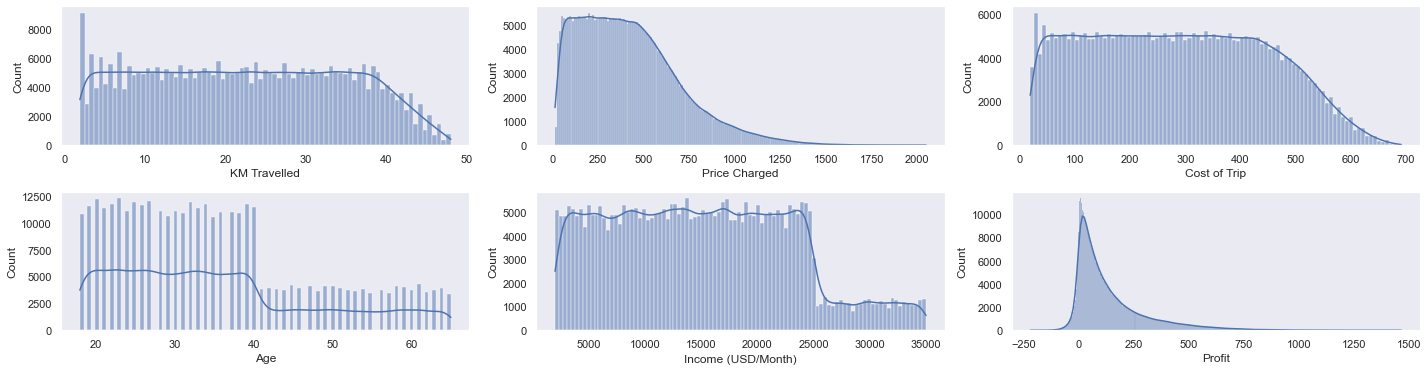

In [75]:
# Density Function for important variables
variable_df = main_df[["KM Travelled", "Price Charged", "Cost of Trip", "Age", "Income (USD/Month)", "Profit"]]

for i,col in enumerate(list(variable_df.columns.values)):
    plt.subplot(4,3,i+1)
    sns.histplot(variable_df[col], color='b', kde=True, label='data')
    plt.grid()
    plt.tight_layout() 

## Correlation & Heatmap

<AxesSubplot:>

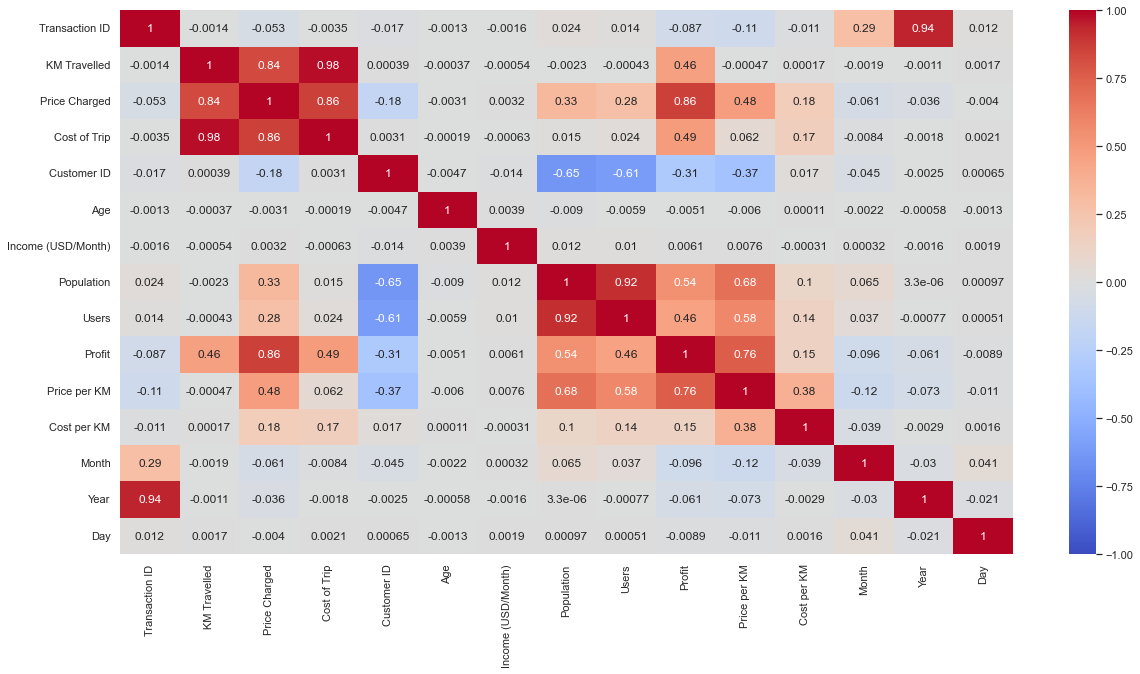

In [39]:
# Creating heatmap 
sns.heatmap(main_df.corr(), annot=True, vmin=-1, vmax=1, cmap="coolwarm")

Discounting the spurrious correlations. Most of the correlations within this heatmap are to be expected such as population and users, or price charged/cost of trip/KM travelled, however, an interesting observation is the weak correlation between population and price charged. This offers the question that perhaps larger cities have more expensive taxis. 

Now we can gather valuable information about the taxi industry in three regions - the location it operates in, the annual breakdown, and important information regarding the customers. 

## EDA: Entire Taxi Industry

### Location 

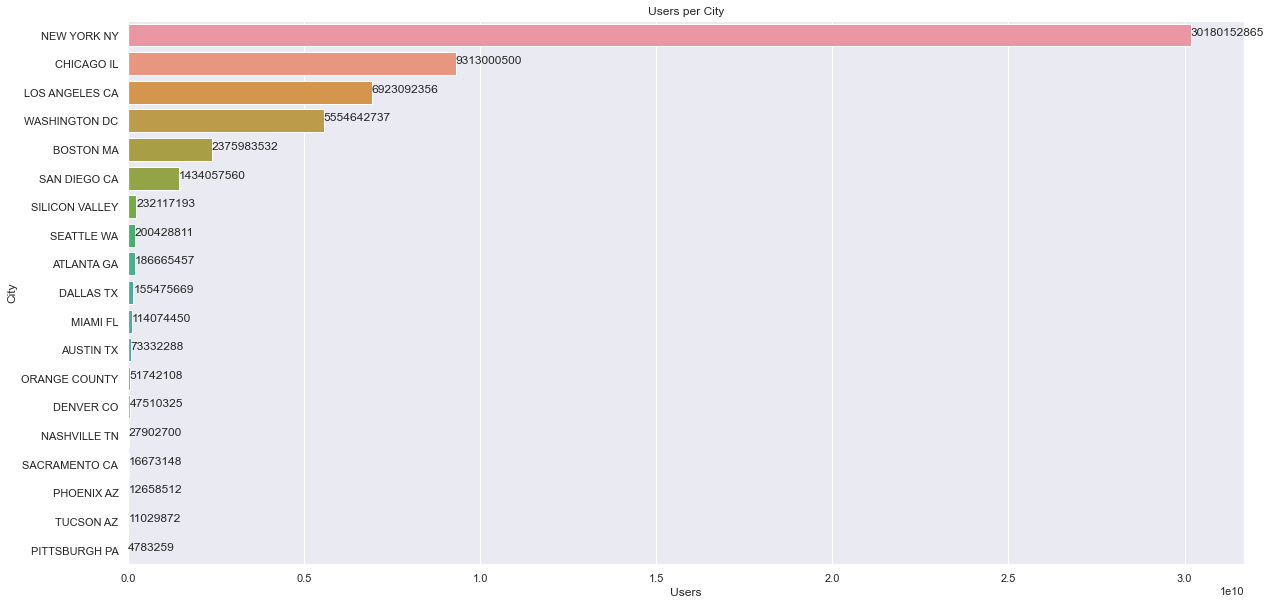

In [40]:
# Observe users per city
# Group by city 
city_users = pd.DataFrame(main_df.groupby("City")["Users"].sum().sort_values(ascending=False))
city_users.reset_index(inplace=True)

# Creating Graph
graph = sns.barplot(x = "Users", y = "City", data = city_users)
plt.title("Users per City")

# Graphing for each group
for i, j in enumerate(city_users.Users):
    graph.text(j, i, str(int(j)))

The pure scale of NYC dominating the taxi space, accounting for over a quarter of all taxi rides between both companies. Outside the top 10 cities, there is a dramatic reduction in taxi users. Now lets observe the profit share of each city. 

<AxesSubplot:ylabel='Profit'>

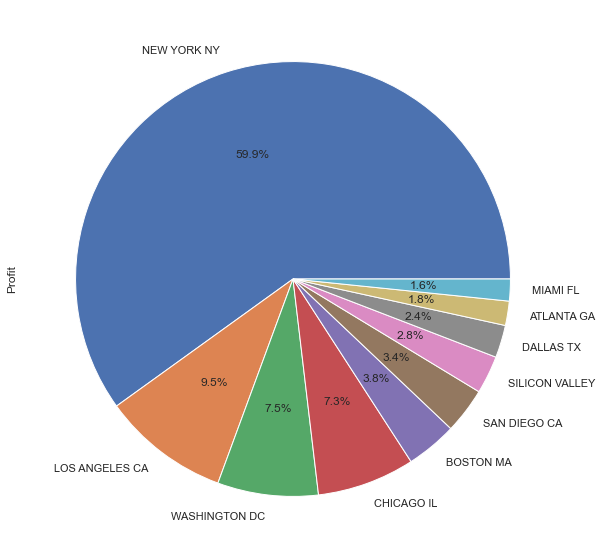

In [41]:
main_df.groupby("City")["Profit"].sum().sort_values(ascending = False).head(10).plot(kind = "pie", autopct = "%1.1f%%")

Despite being responsible for just a quarter of total taxi users, NY results in almost 60% of total profit by the taxi industry, therefore it is high user, highly profitable region. Later we will inspect each taxi company's operation in these areas. 

### Time Period

In [15]:
# Convert time data into usable datapoints 
main_df["Date of Travel"] = main_df["Date of Travel"].apply(lambda d: xlrd.xldate.xldate_as_datetime(d, 0))

# Stripping out usable data
main_df["Month"] = main_df["Date of Travel"].dt.month
main_df["Year"] = main_df["Date of Travel"].dt.year
main_df["Day"] = main_df["Date of Travel"].dt.day

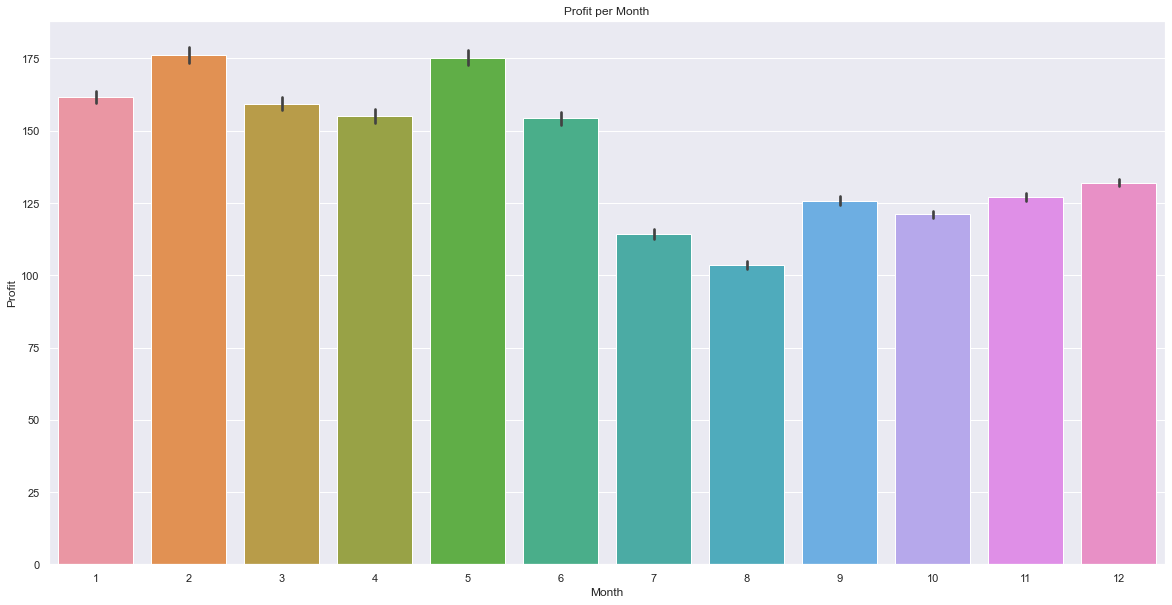

In [78]:
# Plotting profit by month
ax = sns.barplot(x = main_df["Month"], y = main_df["Profit"], data = main_df)
plt.title("Profit per Month")
plt.show()

Note that on average the late summer months result in the lowest profits for the taxi industry. However, the most profitable months are February and May not exactly the peak winter months around November and December.

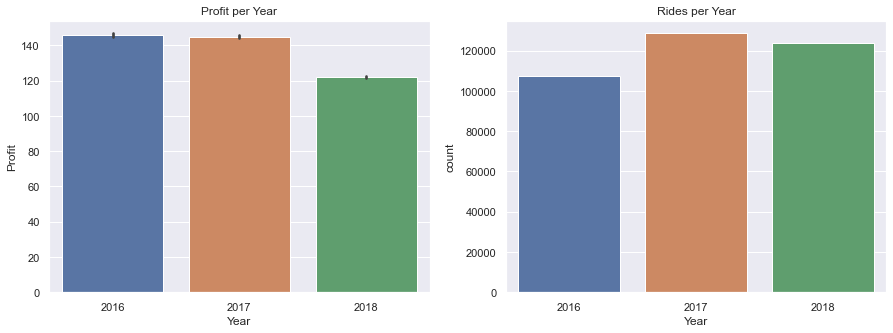

In [77]:
# Plotting profit by year
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.barplot(data = main_df, x = main_df["Year"], y = main_df["Profit"], ax=ax[0]).set_title("Profit per Year")
sns.countplot(x = main_df["Year"], data = main_df, ax=ax[1]).set_title("Rides per Year")
plt.show()

This is a most inauspicious observervation, the total profit in the taxi industry has reduced in the final year of available data (2018), while number of rides does not. This poses many questions for investors. 

### Consumer

Text(0.5, 1.0, 'Cab Profit by Gender')

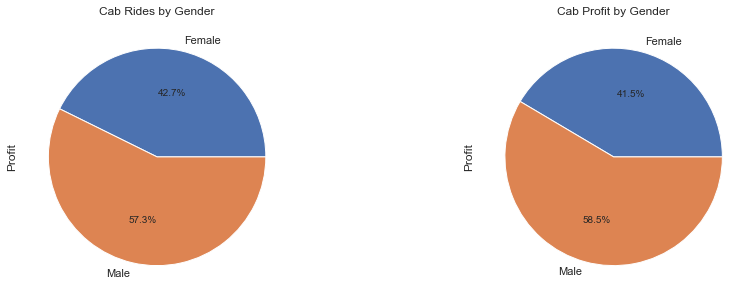

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting interesting gender insights on cab use and profitability 
main_df.groupby("Gender")["Profit"].count().plot(kind = "pie", y = "GENDER", autopct="%1.1f%%", ax = ax[0]).set_title("Cab Rides by Gender")
main_df.groupby("Gender")["Profit"].sum().plot(kind = "pie", y = "GENDER", autopct="%1.1f%%", ax = ax[1]).set_title("Cab Profit by Gender")

Text(0.5, 1.0, 'Taxi Riders by Sex & Age Group')

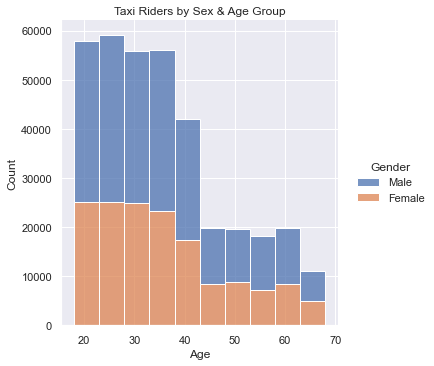

In [19]:
# Plotting riders by sex and age 
sns.displot(main_df, x = "Age", binwidth = 5, bins = [10, 20, 30, 40, 50, 60, 70, 80], hue = "Gender",  multiple = "stack")
plt.title("Taxi Riders by Sex & Age Group")

## EDA: Yellow vs Pink Cab Companies 

In [20]:
# Splitting between pink and yellow taxi cab companies 
yellow_df = main_df[main_df["Company"] == "Yellow Cab"]

# Statistical Insights 
yellow_df.describe().apply(lambda s: s.apply("{0:.2f}".format)).T

,count,mean,std,min,25%,50%,75%,max
Transaction ID,274681.00,10219781.39,126982.92,10000384.00,10110836.00,10219868.00,10329386.00,10440107.00
KM Travelled,274681.00,22.57,12.23,1.90,11.99,22.44,32.96,48.00
Price Charged,274681.00,458.18,288.39,20.73,226.68,425.06,633.88,2048.03
Cost of Trip,274681.00,297.92,162.55,22.80,158.40,295.60,432.43,691.20
Customer ID,274681.00,19428.83,21830.79,1.00,2403.00,6445.00,38916.00,60000.00
Age,274681.00,35.34,12.58,18.00,25.00,33.00,42.00,65.00
Income (USD/Month),274681.00,15045.67,7962.73,2000.00,8439.00,14676.00,21023.00,34996.00
Population,274681.00,3373228.31,3439014.40,248968.00,671238.00,1595037.00,8405837.00,8405837.00
Users,274681.00,168473.25,100570.56,3643.00,80021.00,144132.00,302149.00,302149.00
Profit,274681.00,160.26,171.82,-176.93,37.18,102.00,228.67,1463.97


In [21]:
pink_df = main_df[main_df["Company"] == "Pink Cab"]

# Statistical Insights 
pink_df.describe().apply(lambda s: s.apply("{0:.2f}".format)).T

,count,mean,std,min,25%,50%,75%,max
Transaction ID,84711.00,10223938.22,126178.21,10000011.00,10110143.50,10225904.00,10336416.50,10437615.00
KM Travelled,84711.00,22.56,12.23,1.90,12.00,22.44,32.96,48.00
Price Charged,84711.00,310.80,182.00,15.60,159.97,298.06,441.50,1623.48
Cost of Trip,84711.00,248.15,135.40,19.00,131.87,246.33,360.18,576.00
Customer ID,84711.00,18422.58,18084.83,1.00,5317.50,8876.00,27190.00,60000.00
Age,84711.00,35.32,12.64,18.00,25.00,33.00,42.00,65.00
Income (USD/Month),84711.00,15059.05,7991.08,2000.00,8371.00,14713.00,21055.00,35000.00
Population,84711.00,2350641.51,2734890.26,248968.00,814885.00,1595037.00,1955130.00,8405837.00
Users,84711.00,125590.81,94593.43,3643.00,27247.00,144132.00,164468.00,302149.00
Profit,84711.00,62.65,77.59,-220.06,11.21,41.50,93.97,1119.48


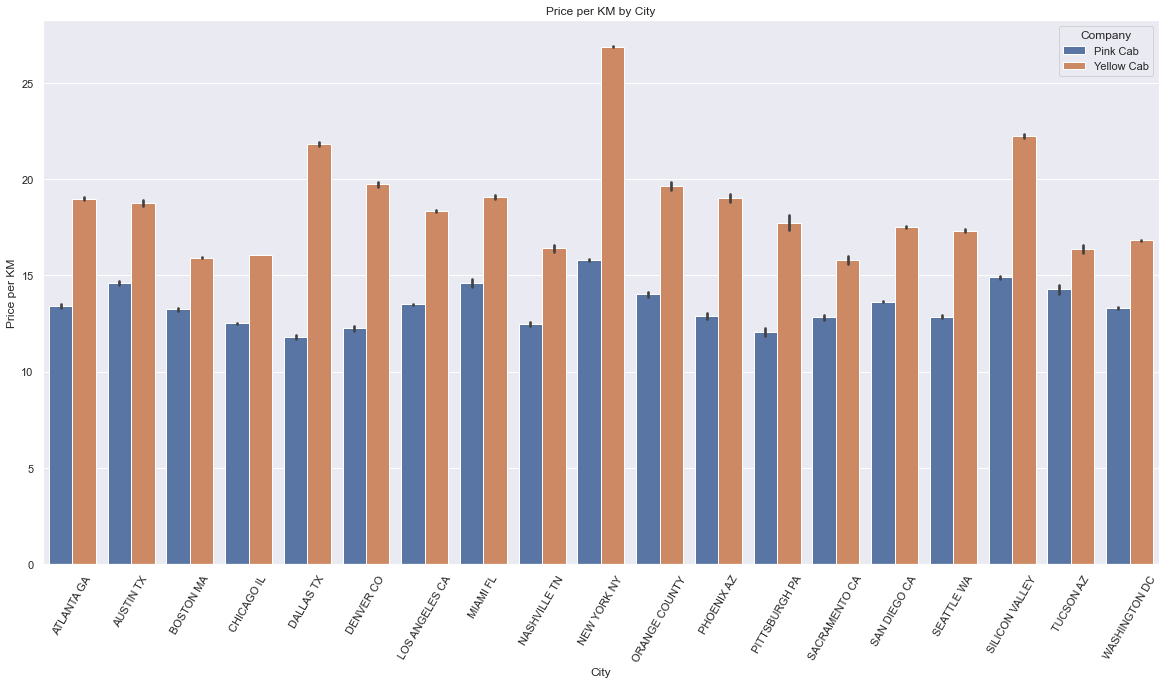

In [90]:
plt.figure(figsize=(20,10))
sns.barplot(x = main_df["City"], y = main_df["Price per KM"], hue = "Company", data = main_df)
plt.xticks(rotation=60)
plt.title("Price per KM by City")
plt.show()

As we can see, across all cities Yellow cab company charges increased prices in comparison to pink. This is most noticable in Nw York, the most profitable and user dense city in the dataset.  

<AxesSubplot:xlabel='Income (USD/Month)', ylabel='Count'>

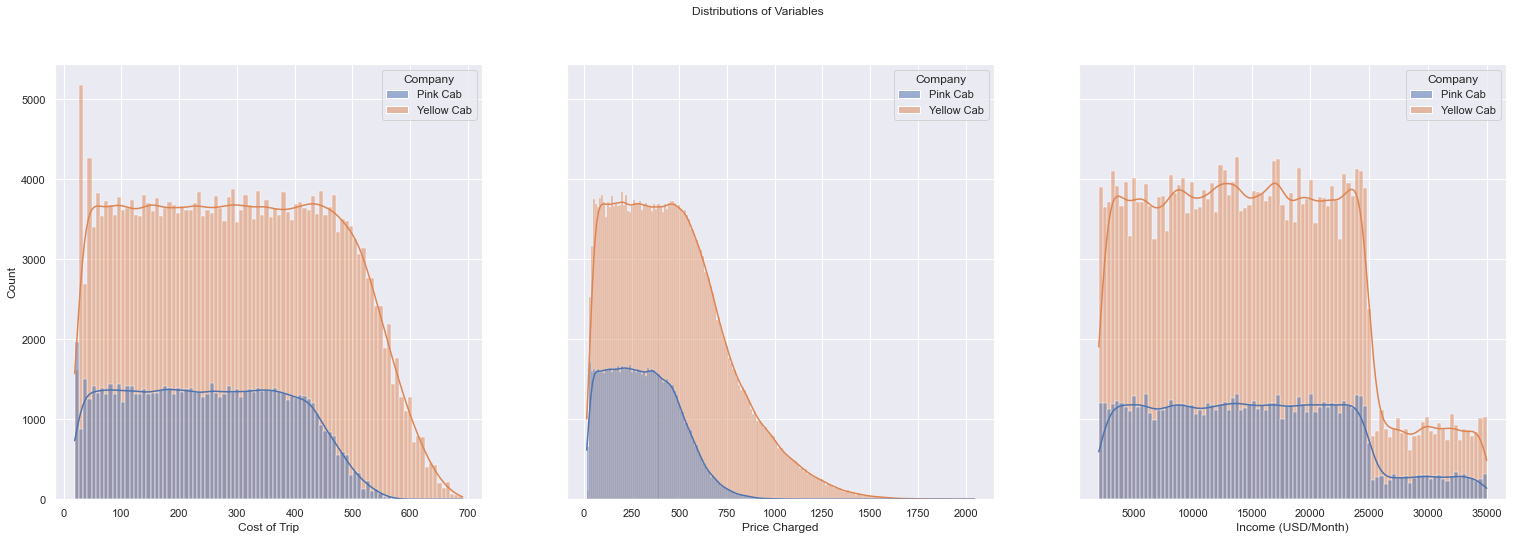

In [23]:
# Plotting distributions of key variables 
fig,axes = plt.subplots(1, 3 , figsize=(26,8), sharey=True)
fig.suptitle('Distributions of Variables')
sns.histplot(ax = axes[0], data = main_df, x = 'Cost of Trip', kde = True, hue = "Company")
sns.histplot(ax = axes[1], data = main_df, x = 'Price Charged', kde = True, hue = "Company")
sns.histplot(ax = axes[2], data = main_df, x = 'Income (USD/Month)', kde = True, hue = "Company") 

Text(0.5, 1.0, 'Taxi Riders by Age Group')

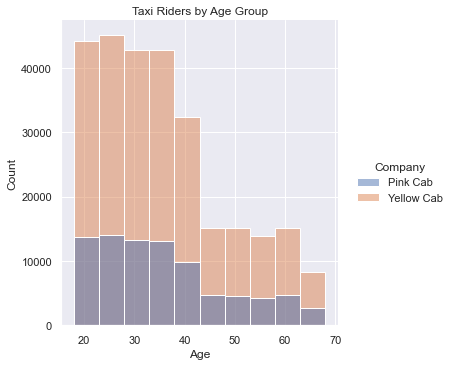

In [24]:
# Its important to analyse the age brackets of each userbase 
sns.displot(main_df, x = "Age", binwidth = 5, bins = [10, 20, 30, 40, 50, 60, 70, 80], hue = "Company")
plt.title("Taxi Riders by Age Group")

Its evident by every comparison that Yellow cab possesses a larger market share, however, how about a profit analysis. 

### Time Series Analysis 

In [62]:
profit_df = main_df[["Company", "Profit", "Cost of Trip", "Price Charged"]]
profit_df.set_index(main_df["Date of Travel"], inplace = True)

# Monthly resample for ease of plotting and inference
re_profit = profit_df.resample("M").mean()

In [63]:
re_profit.head()

,Profit,Cost of Trip,Price Charged
Date of Travel,,,
2016-01-31,195.923585,289.953843,485.877428
2016-02-29,191.587127,287.579782,479.166910
2016-03-31,157.215927,291.548396,448.764323
2016-04-30,155.867920,289.423690,445.291611
2016-05-31,178.434347,285.264789,463.699136


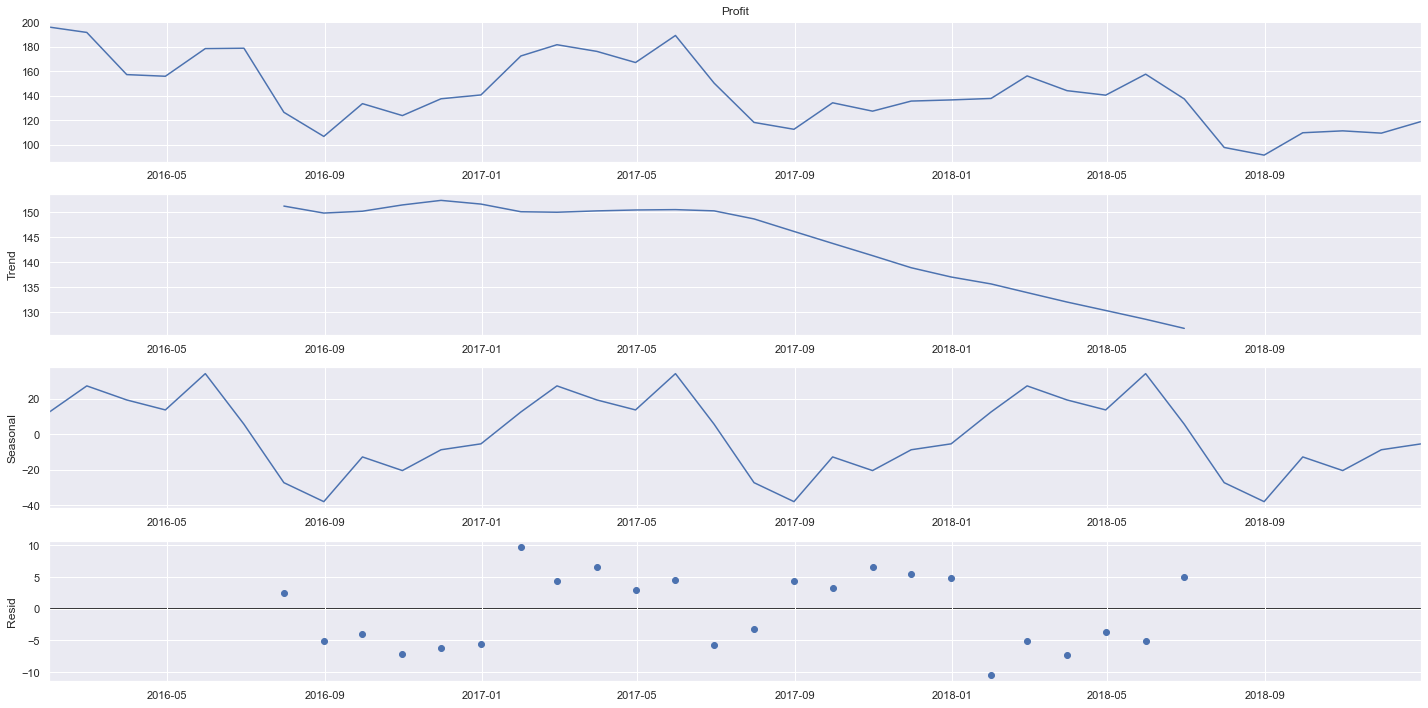

In [64]:
# Observing seasonality and fluctuations of profit within the dataset
decomposition = sm.tsa.seasonal_decompose(re_profit["Profit"], model='additive')
fig = decomposition.plot()
plt.show()

In [58]:
yellow_rev = profit_df[profit_df["Company"] == "Yellow Cab"]
yellow_rev["% Change"] = yellow_rev["Profit"].pct_change(periods = -1)
yellow_rev = yellow_rev.resample("M").mean()

pink_rev = profit_df[profit_df["Company"] == "Pink Cab"]
pink_rev["% Change"] = pink_rev["Profit"].pct_change(periods = -1)
pink_rev = pink_rev.resample("M").mean()

C:\Users\Csome\AppData\Local\Temp\ipykernel_24196\1135587782.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yellow_rev["% Change"] = yellow_rev["Profit"].pct_change(periods = -1)
C:\Users\Csome\AppData\Local\Temp\ipykernel_24196\1135587782.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pink_rev["% Change"] = pink_rev["Profit"].pct_change(periods = -1)


In [59]:
yellow_rev["% Change"] = yellow_rev["Profit"].pct_change(periods = -1)
yellow_rev.head()

,Profit,Cost of Trip,Price Charged,% Change
Date of Travel,,,,
2016-01-31,224.874458,300.038088,524.912546,0.041513
2016-02-29,215.911248,297.188780,513.100028,0.214607
2016-03-31,177.762298,301.615806,479.378103,0.007049
2016-04-30,176.517989,300.319160,476.837149,-0.178902
2016-05-31,214.977948,295.542838,510.520786,-0.026071


In [60]:
pink_rev.head()

,Profit,Cost of Trip,Price Charged,% Change
Date of Travel,,,,
2016-01-31,79.776551,249.497203,329.273754,1.967536
2016-02-29,83.310042,244.806015,328.116057,-0.028546
2016-03-31,71.325088,249.463190,320.788278,-3.268189
2016-04-30,66.606333,242.327143,308.933476,1.583467
2016-05-31,39.279488,246.126868,285.406356,13.153561


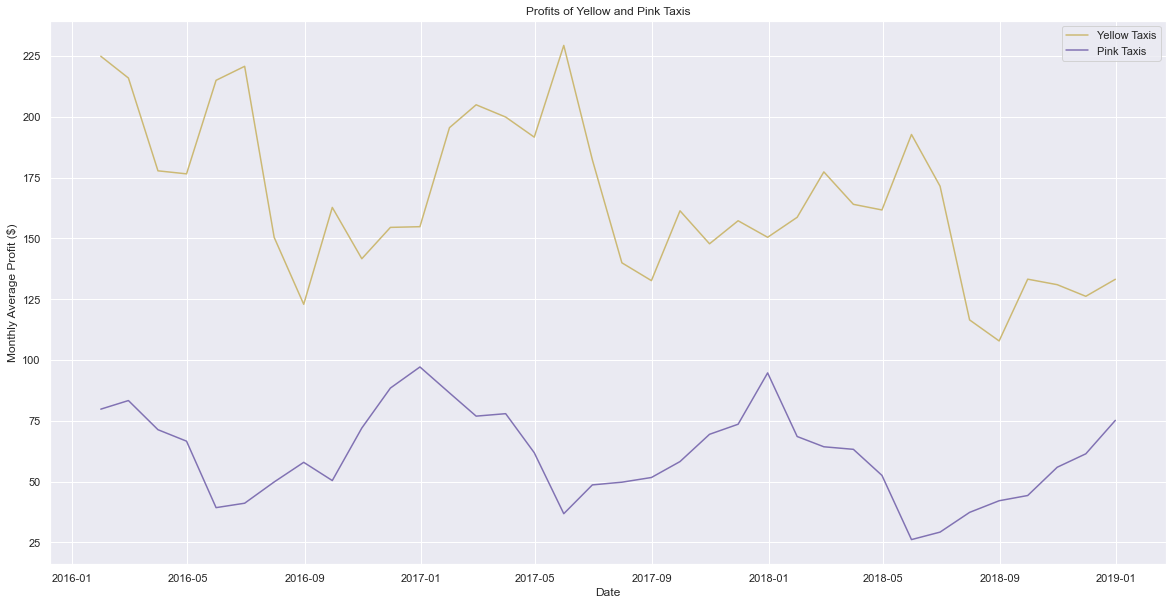

In [65]:
plt.plot(yellow_rev.index, yellow_rev['Profit'], 'y-', label = 'Yellow Taxis')
plt.plot(pink_rev.index, pink_rev['Profit'], 'm-', label = 'Pink Taxis')

plt.xlabel('Date'); plt.ylabel('Monthly Average Profit ($)'); plt.title('Profits of Yellow and Pink Taxis')
plt.legend();

## Inferential Statistics

In [81]:
# Q1: Is there seasonality in the taxi industry?

# H0: There is seasonality (Not Stationary)
# H1: There is no seasonality (Stationary)

# Performing Augmented Dicky Fuller Test for Stationary data
X = re_profit["Profit"]
result = adfuller(X)

# Printing out results at varying degrees of confidence
print('ADF Statistic: %f' % result[0])
print('P-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.217334
p-value: 0.973217
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633


We fail to reject the null hypothesis as there is insufficient evidence that there is no seasonality in the data. 

In [87]:
# Q2: Is there a relationship between cities and the taxi company? 

# H0: There is no relationship between cities and their taxi company 
# H1: There is a relationship between cities and their taxi company

company_city = pd.crosstab(main_df["City"], main_df["Company"])
statistic, p, dof, expected = scipy.stats.chi2_contingency(company_city)

print(f"DOF: {dof}\nP-Value: {p}")

DOF: 18
P-Value: 0.0


We reject the null hypothesis as there is insufficient evidence that there is no link between cities and their taxi company

In [88]:
# Q3: Is there is a company preference by age?
company_age = pd.crosstab(main_df["Age"], main_df["Company"])
statistic, p, dof, expected = scipy.stats.chi2_contingency(company_city)

print(f"DOF: {dof}\nP-Value: {p}")

DOF: 18
P-Value: 0.0


We reject the null hypothesis as there is insufficient evidence that there is no link between age and their taxi company